In [1]:
#All imports

import warnings
warnings.filterwarnings('ignore')

import os
from xml.etree import  ElementTree

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Step 1 - Data Reading and Understanding**

In [3]:
#Load the dataset
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NeuralNetwork/ObjectDetection/JanataHack_ComputerVision/train/train.csv')
train_df.sort_values(by='image_names').head(10)

,image_names,emergency_or_not
880,0.jpg,1
1489,1.jpg,1
545,10.jpg,1
1325,1002.jpg,0
1318,1003.jpg,0
200,1005.jpg,0
590,1006.jpg,0
524,1007.jpg,0
1245,1008.jpg,0
447,1009.jpg,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_names       1646 non-null   object
 1   emergency_or_not  1646 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 25.8+ KB


In [5]:
#Read test data
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NeuralNetwork/ObjectDetection/JanataHack_ComputerVision/test.csv')
test_df.sort_values(by='image_names').head(10)

,image_names
96,100.jpg
684,1000.jpg
587,1001.jpg
240,1004.jpg
705,1014.jpg
552,1017.jpg
43,1025.jpg
702,1027.jpg
380,1029.jpg
635,1033.jpg


**Model Preparation**

In [6]:
cd  /content/drive/MyDrive/Colab\ Notebooks/NeuralNetwork/ObjectDetection/JanataHack_ComputerVision

/content/drive/MyDrive/Colab Notebooks/NeuralNetwork/ObjectDetection/JanataHack_ComputerVision


In [7]:
!git clone https://github.com/matterport/Mask_RCNN.git

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [7]:
cd Mask_RCNN/

/content/drive/MyDrive/Colab Notebooks/NeuralNetwork/ObjectDetection/JanataHack_ComputerVision/Mask_RCNN


In [8]:
!python setup.py install

/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:645: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:645: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:645: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manif

In [9]:
pip show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /usr/local/lib/python3.7/dist-packages/mask_rcnn-2.1-py3.7.egg
Requires: 
Required-by: 


In [10]:
from mrcnn.utils import Dataset
from mrcnn.utils import extract_bboxes
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap

Using TensorFlow backend.


In [11]:
class VehicleDataset(Dataset):
  def load_dataset(self, dataset_dir, images_list):
    self.add_class("dataset", 1, "emergency")
    self.add_class("dataset", 0, "non-emergency")

    images_dir = dataset_dir + "/images/"
    annotations_dir = dataset_dir + "/annot/"   

    for img in images_list:
        img_num = img[:-4]        
        img_path = images_dir + "/" + img
        annot_path = annotations_dir + "/" + img_num + ".xml"
        if not os.path.isfile(annot_path):
          continue       
        
        self.add_image('dataset', img_num, path=img_path, annotation=annot_path)

  def extract_boxes(self, annotation_file):
    tree = ElementTree.parse(annotation_file)
    root = tree.getroot()

    boxes = list()
    for obj in root.findall('.//object'):
      box = obj.find('.//bndbox')
      xmin = int(box.find('xmin').text)
      ymin = int(box.find('ymin').text)
      xmax = int(box.find('xmax').text)
      ymax = int(box.find('ymax').text)

      label = int(obj.find('name').text)
      details = [xmin, ymin, xmax, ymax, label]
      boxes.append(details)

    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    return boxes, width, height

  def load_mask(self, img_id):
    img_info = self.image_info[img_id]
    annot_path = img_info['annotation']

    boxes, width, height = self.extract_boxes(annot_path)
    masks = np.zeros([height, width, len(boxes)], dtype='uint8')

    class_labels = list()
    for i in range(len(boxes)):
      box = boxes[i]
      row_s, row_e = box[1], box[3]
      col_s, col_e = box[0], box[2]
      masks[row_s:row_e, col_s:col_e, i] = 1
      class_labels.append(box[4])

    return masks, np.asarray(class_labels, dtype='uint8')

  def image_reference(self, img_id):
    img_info = self.image_info[img_id]
    return img_info['path'] 

In [12]:
class VehicleConfig(Config):
  NAME = "vehicle_cfg"
  NUM_CLASSES = 3
  STEPS_PER_EPOCH = 1294

In [13]:
X = train_df['image_names']
y = train_df['emergency_or_not']

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, stratify=y)

In [14]:
train_data = VehicleDataset()
train_data.load_dataset('/content/drive/MyDrive/Colab Notebooks/NeuralNetwork/ObjectDetection/JanataHack_ComputerVision/train/', X_train)
train_data.prepare()

val_data = VehicleDataset()
val_data.load_dataset('/content/drive/MyDrive/Colab Notebooks/NeuralNetwork/ObjectDetection/JanataHack_ComputerVision/train/', X_val)
val_data.prepare()

vehicle_config = VehicleConfig()

**Modelling**

In [15]:
model = MaskRCNN(mode='training', model_dir='./', config=vehicle_config)
model.load_weights('/content/drive/MyDrive/Colab Notebooks/NeuralNetwork/ObjectDetection/JanataHack_ComputerVision/mask_rcnn_coco.h5', by_name=True, 
                   exclude=['mrcnn_class_logits','mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [16]:
model.train(train_dataset=train_data, val_dataset=val_data, learning_rate=vehicle_config.LEARNING_RATE,
            epochs=10, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./vehicle_cfg20210407T0350/mask_rcnn_vehicle_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (T

**Inferences - Using the model generated by 9th epoch as it gives minimum validation loss**

In [21]:
class VehiclePredictionConfig(Config):
  NAME = "vehicle_cfg"
  NUM_CLASSES = 3
  IMAGES_PER_GPU = 1
  GPU_COUNT = 1

In [22]:
pred_cfg = VehiclePredictionConfig()
model = MaskRCNN(mode='inference', model_dir='./', config=pred_cfg)
model.load_weights('./mask_rcnn_vehicle_cfg_0009.h5', by_name=True)

In [27]:
def compute_mean_average_precision(model, dataset):
  APs = list()
  for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, pred_cfg, image_id, use_mini_mask=False)
    scaled_image = mold_image(image, pred_cfg)
    scaled_image = np.expand_dims(scaled_image, 0)
    
    pred = model.detect(scaled_image, verbose=0)
    pred = pred[0]
    AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, pred["rois"], pred["class_ids"], pred["scores"], pred['masks'])
    if np.isnan(AP):
      print ("Nan AP computed for image: ", image_id)
      continue

    APs.append(AP)
  # calculate the mean AP across all images
  mAP = np.mean(APs)
  return mAP

In [28]:
print ("mAP on train dataset: ", compute_mean_average_precision(model, train_data))
print ("mAP on validation dataset: ", compute_mean_average_precision(model, val_data))

Nan AP computed for image:  439
Nan AP computed for image:  666
Nan AP computed for image:  847
Nan AP computed for image:  901
mAP on train dataset:  0.5079453067478213
Nan AP computed for image:  191
Nan AP computed for image:  345
mAP on validation dataset:  0.4976190477351605


**Prediction on test images**

In [38]:
test_image_names = []
test_labels = []
image_dir = '/content/drive/MyDrive/Colab Notebooks/NeuralNetwork/ObjectDetection/JanataHack_ComputerVision/train/images/'
for img_id in test_df['image_names']:
  test_img_path = image_dir + "/" + img_id
  if not os.path.isfile(test_img_path):
    print ("test image: {} does not exist".format(test_img_path))
    continue

  test_img = tf.keras.preprocessing.image.load_img(test_img_path)
  test_img = np.array(test_img)
  scaled_img = test_img
  #scaled_img = mold_image(test_img, pred_cfg)
  scaled_img = np.expand_dims(scaled_img, 0)
  pred = model.detect(scaled_img)
  pred = pred[0]

  pred_labels = pred['class_ids']
  if len(pred_labels) == 0:
    print ("Couldn't classify image: {}".format(img_id))
    continue

  max_score_index = np.argmax(pred['scores'])
  pred_label = pred_labels[max_score_index]

  test_image_names.append(img_id)
  test_labels.append(pred_label)

In [50]:
submission_df = pd.DataFrame({'image_names':test_image_names, 'emergency_or_not':test_labels})
submission_df.to_csv('./submission.csv', index=False)

**TEST CODE**

In [31]:
image_dir = '/content/drive/MyDrive/Colab Notebooks/NeuralNetwork/ObjectDetection/JanataHack_ComputerVision/train/images/'
test_img_path = image_dir + "/420.jpg"
test_img = tf.keras.preprocessing.image.load_img(test_img_path)
test_img = np.array(test_img)
#scaled_img = test_img
scaled_img = mold_image(test_img, pred_cfg)
scaled_img = np.expand_dims(scaled_img, 0)
pred = model.detect(scaled_img)
pred = pred[0]

In [32]:
pred

{'class_ids': array([], dtype=int32),
 'masks': array([], shape=(224, 224, 0), dtype=float64),
 'rois': array([], shape=(0, 4), dtype=int32),
 'scores': array([], dtype=float32)}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


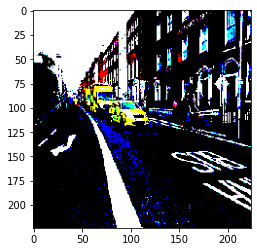

In [35]:
plt.imshow(scaled_img[0,:,:,:])

In [29]:
from matplotlib.patches import Rectangle

[ 90  78 126 122]
[ 75  53 112 101]


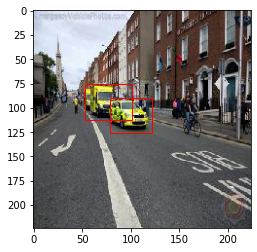

In [30]:
figure, ax = plt.subplots(1)
rois = pred['rois']
ax.imshow(test_img)
for box in rois:
	# get coordinates
  print(box)
  y1, x1, y2, x2 = box
	# calculate width and height of the boxw
  width, height = x2 - x1, y2 - y1
  # create the shape
  rect = Rectangle((x1, y1), width, height, fill=False, color='red')
  # draw the box
  ax.add_patch(rect)
plt.show()

In [36]:
backup_test_image_names = test_image_names.copy()
backup_test_labels = test_labels.copy()

In [37]:
len(backup_test_labels)

705

In [40]:
test_image_names_1 = test_image_names.copy()
test_labels_1 = test_labels.copy()

In [42]:
test_image_names_1.index('420.jpg')

297

In [43]:
test_image_names_1.pop(297)

'420.jpg'

In [44]:
len(test_image_names_1)

705

In [45]:
test_labels_1.pop(297)

1

In [46]:
len(test_labels_1)

705

In [48]:
backup_test_labels == test_labels_1

True